Part a

In [1]:
import gensim.downloader as api

print("Loading model... (This may take a few minutes the first time)")
model = api.load("word2vec-google-news-300")
print("Model loaded successfully!")

words = ['king', 'computer', 'food', 'love', 'movie']

for word in words:
    if word in model.key_to_index:
        print(f"\nTop 5 similar words to '{word}':")
        print(model.most_similar(word, topn=5))
    else:
        print(f"'{word}' not in vocabulary.")

# Example 1: king - man + woman ~= queen
result1 = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print("\nking - man + woman = ", result1)

# Example 2: paris - france + italy ~= rome
result2 = model.most_similar(positive=['paris', 'italy'], negative=['france'], topn=1)
print("paris - france + italy = ", result2)

# Example 3: walking - walk + swim ~= swimming
result3 = model.most_similar(positive=['walking', 'swim'], negative=['walk'], topn=1)
print("walking - walk + swim = ", result3)


Loading model... (This may take a few minutes the first time)
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model loaded successfully!

Top 5 similar words to 'king':
[('kings', 0.7138045430183411), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474)]

Top 5 similar words to 'computer':
[('computers', 0.7979379892349243), ('laptop', 0.6640493273735046), ('laptop_computer', 0.6548868417739868), ('Computer', 0.647333562374115), ('com_puter', 0.6082080006599426)]

Top 5 similar words to 'food':
[('foods', 0.6804922819137573), ('Food', 0.6538903713226318), ('foodstuffs', 0.642582893371582), ('meals', 0.616668701171875), ('food_stuffs', 0.5928642153739929)]

Top 5 similar words to 'love':
[('loved', 0.6907791495323181), ('adore', 0.6816873550415039), ('loves', 0.661863386631012), ('passion', 0.6100708842277527), ('hate', 0.600395679473877)]

Top 5 similar words to 'movie

part b

In [2]:
# ==================================
# STEP 0: IMPORT LIBRARIES
# ==================================
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import gensim
from gensim.models import Word2Vec, FastText
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

print(df.head())
print(df['sentiment'].value_counts())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


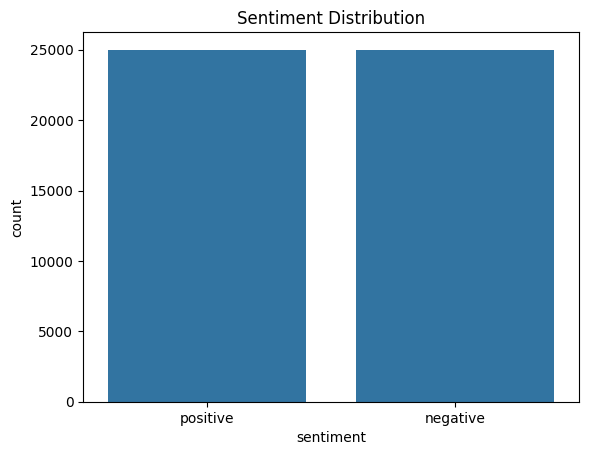

In [4]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

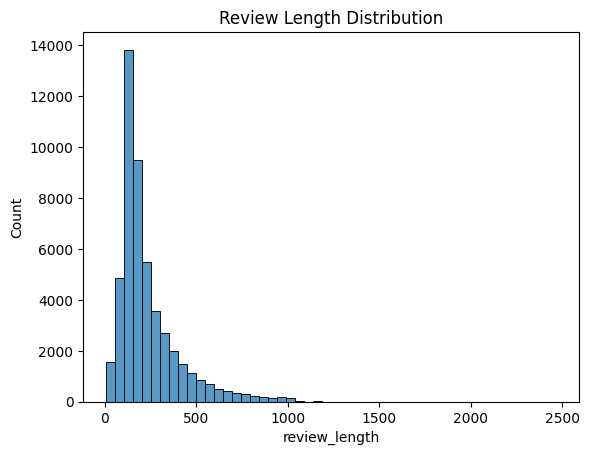

In [5]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.show()

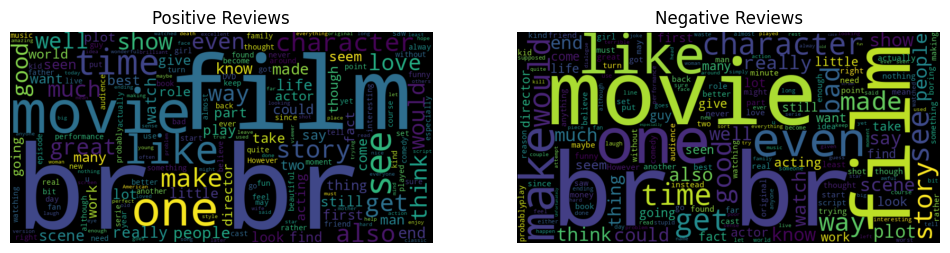

In [6]:
stop_words = set(stopwords.words('english'))
pos_text = ' '.join(df[df['sentiment'] == 'positive']['review'])
neg_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

wc_pos = WordCloud(width=800, height=400, stopwords=stop_words, background_color='black').generate(pos_text)
wc_neg = WordCloud(width=800, height=400, stopwords=stop_words, background_color='black').generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("Positive Reviews")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("Negative Reviews")
plt.axis('off')
plt.show()

In [8]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)        # remove HTML
    text = re.sub(r'http\S+', '', text)      # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)     # keep only letters
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

df['tokens'] = df['review'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

import gensim.downloader as api
print("Loading pre-trained word2vec-google-news-300...")
w2v_pretrained = api.load("word2vec-google-news-300")

def get_avg_w2v(tokens, model, k=300):
    vecs = [model[word] for word in tokens if word in model.key_to_index]
    if len(vecs) == 0:
        return np.zeros(k)
    return np.mean(vecs, axis=0)

X_train_w2v = np.array([get_avg_w2v(tokens, w2v_pretrained) for tokens in X_train])
X_test_w2v  = np.array([get_avg_w2v(tokens, w2v_pretrained) for tokens in X_test])

model_pretrained = LogisticRegression(max_iter=1000)
model_pretrained.fit(X_train_w2v, y_train)
y_pred_pretrained = model_pretrained.predict(X_test_w2v)

acc_pretrained = accuracy_score(y_test, y_pred_pretrained)
f1_pretrained = f1_score(y_test, y_pred_pretrained, pos_label='positive')
print("Pre-trained Word2Vec - Accuracy:", acc_pretrained, "F1:", f1_pretrained)


Loading pre-trained word2vec-google-news-300...
Pre-trained Word2Vec - Accuracy: 0.8532 F1: 0.8529647435897436


In [10]:
w2v_cbow = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=2, sg=0)
w2v_skip = Word2Vec(sentences=X_train, vector_size=100, window=5, min_count=2, sg=1)

def get_avg_custom_w2v(tokens, model):
    vecs = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(model.vector_size)

X_train_cbow = np.array([get_avg_custom_w2v(tokens, w2v_cbow) for tokens in X_train])
X_test_cbow  = np.array([get_avg_custom_w2v(tokens, w2v_cbow) for tokens in X_test])

X_train_skip = np.array([get_avg_custom_w2v(tokens, w2v_skip) for tokens in X_train])
X_test_skip  = np.array([get_avg_custom_w2v(tokens, w2v_skip) for tokens in X_test])

model_cbow = LogisticRegression(max_iter=1000)
model_cbow.fit(X_train_cbow, y_train)
y_pred_cbow = model_cbow.predict(X_test_cbow)

model_skip = LogisticRegression(max_iter=1000)
model_skip.fit(X_train_skip, y_train)
y_pred_skip = model_skip.predict(X_test_skip)

acc_cbow = accuracy_score(y_test, y_pred_cbow)
f1_cbow = f1_score(y_test, y_pred_cbow, pos_label='positive')

acc_skip = accuracy_score(y_test, y_pred_skip)
f1_skip = f1_score(y_test, y_pred_skip, pos_label='positive')

print("CBOW - Accuracy:", acc_cbow, "F1:", f1_cbow)
print("Skip-gram - Accuracy:", acc_skip, "F1:", f1_skip)


CBOW - Accuracy: 0.8566 F1: 0.8570289132602193
Skip-gram - Accuracy: 0.875 F1: 0.8750749550269838


In [12]:
ft_model = FastText(sentences=X_train, vector_size=100, window=5, min_count=2)

X_train_ft = np.array([get_avg_custom_w2v(tokens, ft_model) for tokens in X_train])
X_test_ft  = np.array([get_avg_custom_w2v(tokens, ft_model) for tokens in X_test])

model_ft = LogisticRegression(max_iter=1000)
model_ft.fit(X_train_ft, y_train)
y_pred_ft = model_ft.predict(X_test_ft)

acc_ft = accuracy_score(y_test, y_pred_ft)
f1_ft = f1_score(y_test, y_pred_ft, pos_label='positive')
print("FastText - Accuracy:", acc_ft, "F1:", f1_ft)




FastText - Accuracy: 0.8473 F1: 0.8476199980041912


In [13]:
results = pd.DataFrame({
    "Model": ["Pretrained W2V", "CBOW W2V", "Skip-gram W2V", "FastText"],
    "Accuracy": [acc_pretrained, acc_cbow, acc_skip, acc_ft],
    "F1-score": [f1_pretrained, f1_cbow, f1_skip, f1_ft]
})
print("\nModel Performance:")
print(results)


Model Performance:
            Model  Accuracy  F1-score
0  Pretrained W2V    0.8532  0.852965
1        CBOW W2V    0.8566  0.857029
2   Skip-gram W2V    0.8750  0.875075
3        FastText    0.8473  0.847620
